<a href="https://colab.research.google.com/github/Ariscott72/IndabaX/blob/main/MemoireProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install scikit-plot

In [2]:
!pip install plotly_express

In [3]:
!pip install tensorflow

**Visualisation des données**

In [4]:
import pandas as pd
import numpy as np
import io
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import random

In [5]:
from google.colab import files
data_to_load = files.upload()

Saving fer2013.csv to fer2013.csv


In [6]:
#importer notre dataset
df = pd.read_csv('fer2013.csv')
df.shape

(35887, 3)

In [7]:
#Pour voir l'ensemble de données a des valeurs manquantes.
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [8]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


**Pré-traitement des données**

In [10]:
CLASS_LABELS  = ['Colere', 'Degout', 'Peur', 'Joie', 'Neutre', 'Triste', "Surpris(e)"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(df['emotion']).count(i) for i in np.unique(df['emotion'])] ,
             color = np.unique(df['emotion']) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [11]:
import cv2
image_size=(48,48)

In [12]:
pixels = df['pixels'].tolist() # Converting the relevant column element into a list for each row
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')] # Splitting the string by space character as a list
  face = np.asarray(face).reshape(width, height) #converting the list to numpy array in size of 48*48
  face = cv2.resize(face.astype('uint8'),image_size) #resize the image to have 48 cols (width) and 48 rows (height)
  faces.append(face.astype('float32')) #makes the list of each images of 48*48 and their pixels in numpyarray form

faces = np.asarray(faces) #converting the list into numpy array
faces = np.expand_dims(faces, -1) #Expand the shape of an array -1=last dimension => means color space
emotions = pd.get_dummies(df['emotion']).to_numpy() #doing the one hot encoding type on emotions

In [13]:
print(faces[0]) #Pixels after preprocessing

[[[ 70.]
  [ 80.]
  [ 82.]
  ...
  [ 52.]
  [ 43.]
  [ 41.]]

 [[ 65.]
  [ 61.]
  [ 58.]
  ...
  [ 56.]
  [ 52.]
  [ 44.]]

 [[ 50.]
  [ 43.]
  [ 54.]
  ...
  [ 49.]
  [ 56.]
  [ 47.]]

 ...

 [[ 91.]
  [ 65.]
  [ 42.]
  ...
  [ 72.]
  [ 56.]
  [ 43.]]

 [[ 77.]
  [ 82.]
  [ 79.]
  ...
  [105.]
  [ 70.]
  [ 46.]]

 [[ 77.]
  [ 72.]
  [ 84.]
  ...
  [106.]
  [109.]
  [ 82.]]]


In [14]:
print(faces.shape)
print(faces[0].ndim)
print(type(faces))

(35887, 48, 48, 1)
3
<class 'numpy.ndarray'>


In [15]:
print(emotions[0]) #Emotion after preprocessing

[1 0 0 0 0 0 0]


## Splitting the dataset
# Scaling the pixels between -1 and 1

In [16]:
x = faces.astype('float32')
x = x / 255.0 #Dividing the pixels by 255 for normalization  => range(0,1)

# Scaling the pixels value in range(-1,1)
x = x - 0.5
x = x * 2.0

In [17]:
print(x[0])

[[[-0.45098037]
  [-0.372549  ]
  [-0.35686272]
  ...
  [-0.5921569 ]
  [-0.6627451 ]
  [-0.6784314 ]]

 [[-0.49019605]
  [-0.52156866]
  [-0.54509807]
  ...
  [-0.56078434]
  [-0.5921569 ]
  [-0.654902  ]]

 [[-0.60784316]
  [-0.6627451 ]
  [-0.5764706 ]
  ...
  [-0.6156863 ]
  [-0.56078434]
  [-0.6313726 ]]

 ...

 [[-0.2862745 ]
  [-0.49019605]
  [-0.67058825]
  ...
  [-0.4352941 ]
  [-0.56078434]
  [-0.6627451 ]]

 [[-0.3960784 ]
  [-0.35686272]
  [-0.38039213]
  ...
  [-0.17647058]
  [-0.45098037]
  [-0.6392157 ]]

 [[-0.3960784 ]
  [-0.4352941 ]
  [-0.34117645]
  ...
  [-0.16862744]
  [-0.14509803]
  [-0.35686272]]]


In [18]:
type(x)

numpy.ndarray

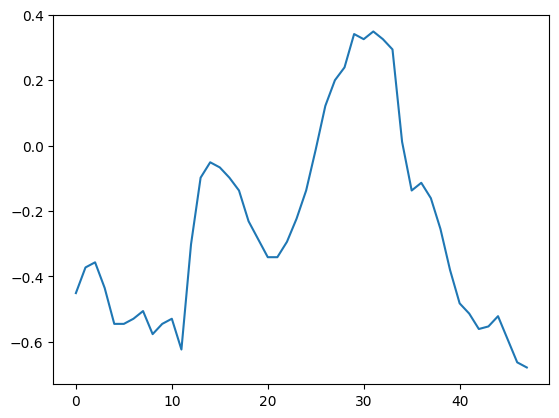

In [19]:
plt.plot(x[0,0])
plt.show()

In [20]:
print(x.min(),x.max()) # we can observe that pixels are scale

-1.0 1.0


**Fractionner le jeu de données dans le jeu d'entraînement et de validation**

In [21]:
num_samples, num_classes = emotions.shape

num_samples = len(x)
num_train_samples = int((1 - 0.2)*num_samples)

# Traning data
train_x = x[:num_train_samples]
train_y = emotions[:num_train_samples]

# Validation data
val_x = x[num_train_samples:]
val_y = emotions[num_train_samples:]

train_data = (train_x, train_y)
val_data = (val_x, val_y)

In [22]:
print('Training Pixels',train_x.shape)  # ==> 4 dims -  no of images , width , height , color
print('Training labels',train_y.shape)

print('Validation Pixels',val_x.shape)
print('Validation labels',val_y.shape)

Training Pixels (28709, 48, 48, 1)
Training labels (28709, 7)
Validation Pixels (7178, 48, 48, 1)
Validation labels (7178, 7)


### Shuffling the data (Mélanger les données)

Tout d'abord, nous allons mélanger les données à l'aide de la fonction sample () et déterminer la fraction comme 1 pour mélanger les données en modifiant les lignes.

In [23]:
data=df.sample(frac=1)

### One Hot Encoding (Un encodage à chaud)

Ensuite, nous effectuerons une opération d'encodage à chaud pour modifier les étiquettes catégorielles, car les étiquettes numériques de l'algorithme d'apprentissage peuvent mieux fonctionner dans le processus de prédiction.

In [24]:
labels = to_categorical(df[['emotion']], num_classes=7)


Changer les pixels de l'image en tableau Numpy


In [25]:
train_pixels = df["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

### Standardisation

Nous allons modifier la structure des données pour alimenter le scaler standard afin de mettre en œuvre le processus de normalisation de nos données. Étant donné que la fonction StandartScaler() ne prend qu'un tableau à 2 dimensions, nous allons remodeler les données, puis appliquer notre scaler pour faire de la moyenne zéro et de l'écart standard comme unité.

In [26]:
pixels = train_pixels.reshape((35887*2304,1))

In [27]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

### Reshaping the data (48,48)

Après cela, nous allons remodeler les données pour que nos pixels d'image soient prêts à être divisés.

In [28]:
pixels = train_pixels.reshape((35887, 48, 48,1))

## Former la division de validation des tests

Maintenant, nous avons 35887 images contenant chacune 48x48 pixels. Nous diviserons les données en données d'apprentissage, de test et de validation pour alimenter, évaluer et valider nos données avec un ratio de 10 %.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)



Nous pouvons voir des données d'entrainement contenant un échantillon de chaque classe à l'aide de ce code de tracé.

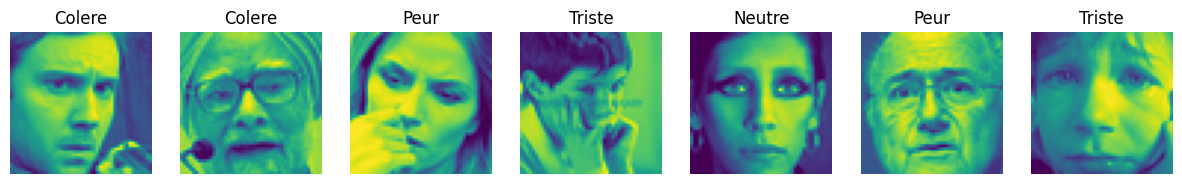

In [31]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Colere', 1 : 'Degout', 2 : 'Peur', 3 : 'Joie', 4 : 'Triste', 5 : 'Surpris(e)', 6 : 'Neutre'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

## Augmentation des données à l'aide d'ImageDataGenerato

Nous pouvons faire une augmentation des données pour avoir plus de données à former et valider notre modèle pour éviter le surajustement. L'augmentation des données peut être effectuée sur des ensembles de formation et de validation, car elle aide le modèle à devenir plus général et plus robuste.

In [32]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [33]:
datagen.fit(X_train)
valgen.fit(X_val)

In [34]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)


Notre jeu de données est prêt à alimenter notre modèle. Nous allons regarder notre architecture de modèle.


#Concevoir un modèle


## Modèle CNN

Le modèle CNN comporte de nombreuses couches avec différentes unités telles que la couche convolutive, la couche de regroupement maximale, la normalisation par lots et la couche d'abandon pour régulariser le modèle.

In [35]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.1/999.1 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 3.0.1 which is incompatible.


In [36]:
input_shape=(48, 48, 1)
num_classes = 7

In [44]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.1
    Uninstalling keras-3.0.1:
      Successfully uninstalled keras-3.0.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully un

In [45]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
# from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from tensorflow.keras.applications import MobileNet

# base_model = MobileNet( weights = 'imagenet', input_shape = (224,224,3), include_top = False )

# for layer in base_model.layers[:-10]:
#     layer.trainable = False

# for layer in base_model.layers[-10:]:
#     layer.trainable = True


# # Entrée pour les images
# image_input = Input(shape=(48, 48, 1), name='image_input')
# z = Conv2D(32, (3, 3), activation='relu')(image_input)
# z = MaxPooling2D((2, 2))(z)
# # ... Ajoutez d'autres couches de votre modèle ici ...

# # Entrée pour les étiquettes
# label_input = Input(shape=(7,), name='label_input')

# # Fusionnez les deux entrées
# z = Flatten()(z)
# combined = concatenate([z, label_input])

# z = base_model.output
# z = Conv2D(filters = 32, kernel_size = (1,1), strides = (1,1), activation = 'relu', padding = 'same')(z)

# z = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(z)

# z = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(z)

# z = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(z)

# z = Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(z)

# z = GlobalAveragePooling2D()(z)

# z = Flatten()(z)

# z = Dense(units = 256 , activation = 'relu' )(z)
# z = Dropout(0.3)(z)

# z = Dense(units = 512 , activation = 'relu' )(z)
# z = Dropout(0.3)(z)

# z = Dense(units=7 , activation = 'softmax' )(z)



# # Couche de sortie
# output = Dense(7, activation='softmax')(combined)

# # Créez le modèle
# model = Model(inputs=[image_input, label_input], outputs=output)


def create_convolutional_model(classes):
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(2,2),strides=(1,1),activation='relu',input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters=128,kernel_size=(2,2),strides=(1,1),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=256,kernel_size=(2,2),strides=(1,1),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(classes,activation='softmax'))


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [46]:
hiddenimports=['tensorflow.python.keras.engine.base_layer_v1']
classes=7
model = create_convolutional_model(classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 47, 32)        160       
                                                                 
 batch_normalization (Batch  (None, 47, 47, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        8256      
                                                                 
 batch_normalization_1 (Bat  (None, 22, 22, 64)        2

In [47]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [48]:
checkpoint = ModelCheckpoint(filepath="mobilenet_1_0_224_tf_no_top.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [49]:
""" Data Augmentation => taking the batch and apply some series of random transformations (random rotation, resizing, shearing)

      ===> to increase generalizability of model  """


# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [50]:
# parameters
batch_size = 32 #Number of samples per gradient update
num_epochs = 200 # Number of epochs to train the model.
#input_shape = (64, 64, 1)
verbose = 1 #per epohs  progress bar
num_classes = 7
patience = 50

datasets = ['fer2013']
num_epochs = 200
base_path="/content"
for dataset_name in datasets:
    print('Training dataset:', dataset_name)

    #callbacks
    log_file_path = dataset_name + '_emotion_training.log'

    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_loss', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(patience/4), verbose=1)

    trained_models_path = base_path + dataset_name + 'simple_cnn'
    model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}.hdf5'      # if error "acc" in 1 line ... don't confuse check entire block since fit() generates a inner loop
    model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
    my_callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

     # loading dataset
    train_faces, train_emotions = train_data
    history=model.fit_generator(data_generator.flow(train_faces, train_emotions,
                                            batch_size),
                        epochs=num_epochs, verbose=1
                        ,callbacks=my_callbacks,validation_data =val_data)   #not callbacks = [my_callbacks] since we m

#    model.fit(X_train, y_train, batch_size=105, epochs=30, verbose=1)

Training dataset: fer2013
Epoch 1/200


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
897/898 [============================>.] - ETA: 0s - loss: 1.9183 - accuracy: 0.2850

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_loss improved from inf to 1.62151, saving model to /contentfer2013simple_cnn.01-1.62.hdf5
898/898 [==============================] - 45s 31ms/step - loss: 1.9179 - accuracy: 0.2851 - val_loss: 1.6215 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 2/200
897/898 [============================>.] - ETA: 0s - loss: 1.6117 - accuracy: 0.3752
Epoch 2: val_loss improved from 1.62151 to 1.36663, saving model to /contentfer2013simple_cnn.02-1.37.hdf5
898/898 [==============================] - 23s 25ms/step - loss: 1.6115 - accuracy: 0.3752 - val_loss: 1.3666 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 3/200
897/898 [============================>.] - ET

In [51]:
#evaluate() returns [loss,acc]
score = model.evaluate(val_x, val_y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

225/225 [==============================] - 1s 5ms/step - loss: 0.9182 - accuracy: 0.6725
Test loss: 0.9182459712028503
Test accuracy: 67.24714636802673


In [52]:

""" metrics collected by history object """
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

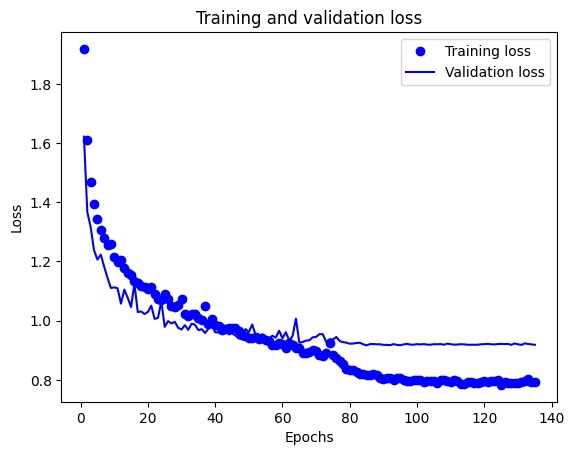

In [53]:
""" Visualising model training history """

import matplotlib.pyplot as plt

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

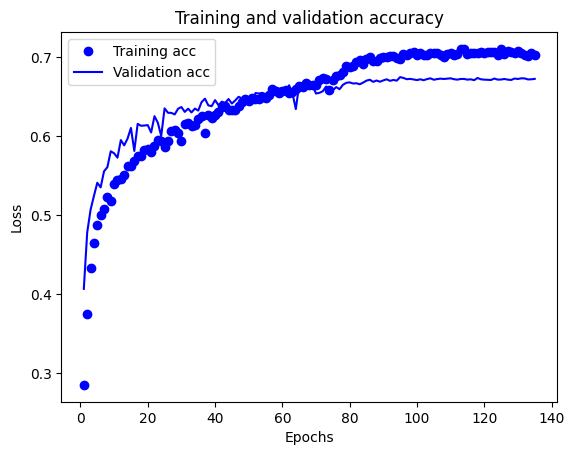

In [54]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Testing the model on some images**

In [ ]:
emotion_dict = {0:"Neutral", 1:"Disgusted", 2:"Fearful", 3:"Happy", 4:"Sad", 5:"Surprised", 6:"Neutral"}

  #emojis unicodes #
 emojis = {0:"\U0001f620", 1:"\U0001f922", 2:"\U0001f628", 3:"\U0001f60A", 4:"\U0001f625", 5:"\U0001f632", 6:"\U0001f610"}

 print(emojis.values(),sep=" ")

IndentationError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import shutil, sys, os, dlib, glob

def _predict(path):
  facecasc = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
  imagePath = '/content/'+path
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=10)
  print("No of faces : ",len(faces))
  i = 1
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]                      #croping
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    prediction = model.predict(cropped_img)

    maxindex = int(np.argmax(prediction))
    print("person ",i," : ",emotion_dict[maxindex], "-->",emojis[maxindex])
    cv2.putText(image, emotion_dict[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                                              #if text is not apeared , change coordinates. it may work

  cv2_imshow(image)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
checkpoint = ModelCheckpoint(filepath="contentfer2013simple_cnn.31-0.97.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [ ]:
hist = model.fit(val_x, val_y, epochs = 25, validation_data = val_data, callbacks = callbacks_list)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 1.0150 - accuracy: 0.6408
Epoch 1: val_accuracy did not improve from 0.68571
225/225 [==============================] - 6s 27ms/step - loss: 1.0150 - accuracy: 0.6408 - val_loss: 0.8990 - val_accuracy: 0.6839 - lr: 2.0000e-08
Epoch 2/25
223/225 [============================>.] - ETA: 0s - loss: 1.0156 - accuracy: 0.6418
Epoch 2: val_accuracy did not improve from 0.68571
225/225 [==============================] - 6s 25ms/step - loss: 1.0138 - accuracy: 0.6424 - val_loss: 0.8998 - val_accuracy: 0.6836 - lr: 2.0000e-08
Epoch 3/25
223/225 [============================>.] - ETA: 0s - loss: 1.0153 - accuracy: 0.6425
Epoch 3: val_accuracy did not improve from 0.68571
225/225 [==============================] - 6s 26ms/step - loss: 1.0167 - accuracy: 0.6421 - val_loss: 0.9004 - val_accuracy: 0.6842 - lr: 2.0000e-08
Epoch 4/25
223/225 [============================>.] - ETA: 0s - loss: 1.0098 - accuracy: 0.6459
Epoch 4: val_acc

In [ ]:
from google.colab import files
files.download('contentfer2013simple_cnn.31-0.97.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.evaluate(X_train, y_train)[1]

909/909 [==============================] - 6s 6ms/step - loss: 92.2517 - accuracy: 0.1910


0.19100041687488556

In [ ]:
c

In [ ]:
# parameters
batch_size = 32 #Number of samples per gradient update
num_epochs = 200 # Number of epochs to train the model.
#input_shape = (64, 64, 1)
verbose = 1 #per epohs  progress bar
num_classes = 7
patience = 50
base_path = 'drive/Colab Notebooks/emotion/simplecnn/'

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("Emotion_Detection.h5")

In [ ]:
!jupyter nbconvert --to pdf /content/MemoireProject.ipynb